# Tracking Ground Truth by  KIT-Sch-GE algorithm

We originally attempted to manually relabel the images to create tracking ground truth.  
Unfortunately we made a mistake, and thus can't use those relabelings to get TRA metrics.  

We propose just applying the KIT tracking algorithm to the ground truth segmentations, and using that as the reference tracking ground truth.  

In initial testing, we see that the tracking results produces many more cells than we previously thought were in the image.  
I believe this is because there are gaps in time between some of the images that are longer than the frame rate.  
That is there was a gap in the video sequence, but they are considered to be part of the same sequence.  
This means every once in a while some cells will jump quite a lot, leading to the tracking algorithm to create new cells (because it looks like the cells split).  

We know this is not the best way to have gotten the ground truth tracking (the labelers should have done it), but this is the best we can do.  
Additionally, since we are applying the tracking algorithm to the same sequence of images from our segmentation models, we would expect there to be similar erroneous cell splitings.  

Copy and rename 02_GT/SEG so that we can apply tracking to it.

# Copy and Rename 02_GT/SEG so that we can apply tracking to it.

In [5]:
import tifffile as tiff
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import os
from PIL import Image
import re
import csv
import shutil
from skimage.morphology import dilation, erosion
from tqdm import tqdm

# Create two folders named TMP_TRA and TMP_TRA2

In [6]:
input_dir = "/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_GT/SEG"
tmp_output = "/home/MinaHossain/DMNet_Rina_Tracking/6row_images/TMP_TRA"
tmp_output2 = "/home/MinaHossain/DMNet_Rina_Tracking/6row_images/TMP_TRA2"

# Make copy of SEG so that we can rename
if os.path.exists(tmp_output):
    shutil.rmtree(tmp_output)
shutil.copytree(input_dir, tmp_output)

# Rename each file
for filename in os.listdir(input_dir):
    og_name = os.path.join(tmp_output, filename)
    nw_name = os.path.join(tmp_output, f'mask{filename.split(".")[0][7:]}.tif')
    os.rename(og_name, nw_name)

# Save copy of the original 02_GT

In [9]:
input_dir = "/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_GT"
copy_dir = "/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_GT_ORIGINAL"

if os.path.exists(copy_dir):
    print("Copy appears to already exist")
else:
    shutil.copytree(input_dir, copy_dir)

# Now we need to apply the tracking algorithm to these images
`cd /home/MinaHossain/DMNet_Rina_Tracking/2021-cell-tracking`  
`conda activate venv_graph_tracking_kit_sch_ge_2021`
" Run the command:" 
"python -m run_tracking --image_path /home/MinaHossain/DMNet_Rina_Tracking/6row_images/02 --segmentation_path /home/MinaHossain/DMNet_Rina_Tracking/6row_images/TMP_TRA --results_path /home/MinaHossain/DMNet_Rina_Tracking/6row_images/TMP_TRA2"

# Place updated tracking frames in 02_GT

In [7]:
final_dir = "/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_GT/TRA"

# Make copy of SEG so that we can rename
if os.path.exists(final_dir):
    shutil.rmtree(final_dir)
shutil.copytree(tmp_output2, final_dir)


# Rename each file
for filename in os.listdir(final_dir):
    fname, extension = os.path.splitext(filename)
    if extension == ".txt":
        os.rename(os.path.join(final_dir, filename), os.path.join(final_dir, "man_track.txt"))
    else:
        og_name = os.path.join(final_dir, filename)
        nw_name = os.path.join(final_dir, f'man_track{filename.split(".")[0][4:]}.tif')
        os.rename(og_name, nw_name)

# Clean up temp directories

In [8]:
shutil.rmtree(tmp_output)
shutil.rmtree(tmp_output2)

# Example of where there appears to be a larger gap in time

In [9]:
def make_np(img):
    return np.array(img)

def shuffle_labels(img, seed=789):
    # Find the unique labels, excluding 0 (background)
    array = make_np(img)
    unique_labels = np.unique(array[array != 0])

    # Generate new labels (random and unique) for each cell type
    # Ensure new labels do not conflict with existing labels
    # max_label = array.max()
    max_label = 0
    new_labels = np.arange(max_label + 1, max_label + 1 + len(unique_labels))

    # Randomly shuffle the new labels
    np.random.seed(seed)
    np.random.shuffle(new_labels)

    # Create a mapping from old labels to new labels
    label_mapping = {old: new for old, new in zip(unique_labels, new_labels)}

    # Apply the mapping to the array
    shuffled_array = np.copy(array)
    for old_label, new_label in label_mapping.items():
        shuffled_array[array == old_label] = new_label
    return shuffled_array

def plot_labels(shuffled, original, ax, title=None,
                txt_args={'color':'red', 'ha':'center', 'va':'center', 
                          'fontsize':'x-large', 'fontweight':'bold'},
                cmap='gist_earth'):
    ax.imshow(shuffled, cmap=cmap)
    ax.set_title(title)
    for label in np.unique(original):
        if label != 0:
            inds = np.argwhere(original == label)
            loc = inds.mean(0)
            ax.text(loc[1], loc[0], str(label), **txt_args)


def read_changes(file_path, row):
    with open(file_path, 'r') as handle:
        reader = csv.reader(handle, delimiter=' ')
        for i in range(row):
            next(reader)
        curr_row = next(reader)
        tuples = [tuple(map(int, item.split(','))) for item in curr_row]
    return tuples

def relabel_image(original, file_path, row):
    tuples = read_changes(file_path, row)
    new_img = original.copy()
    for t in tuples:
        new_img[original == t[0]] = t[1]
    return new_img

# Previous resuts (commented out) can be obtained from the Data located in the data directory  /data/MinaHossain/Cell_Data/Training/6row_images_Trained or /data/MinaHossain/Cell_Data/Training/6row_images_Track.

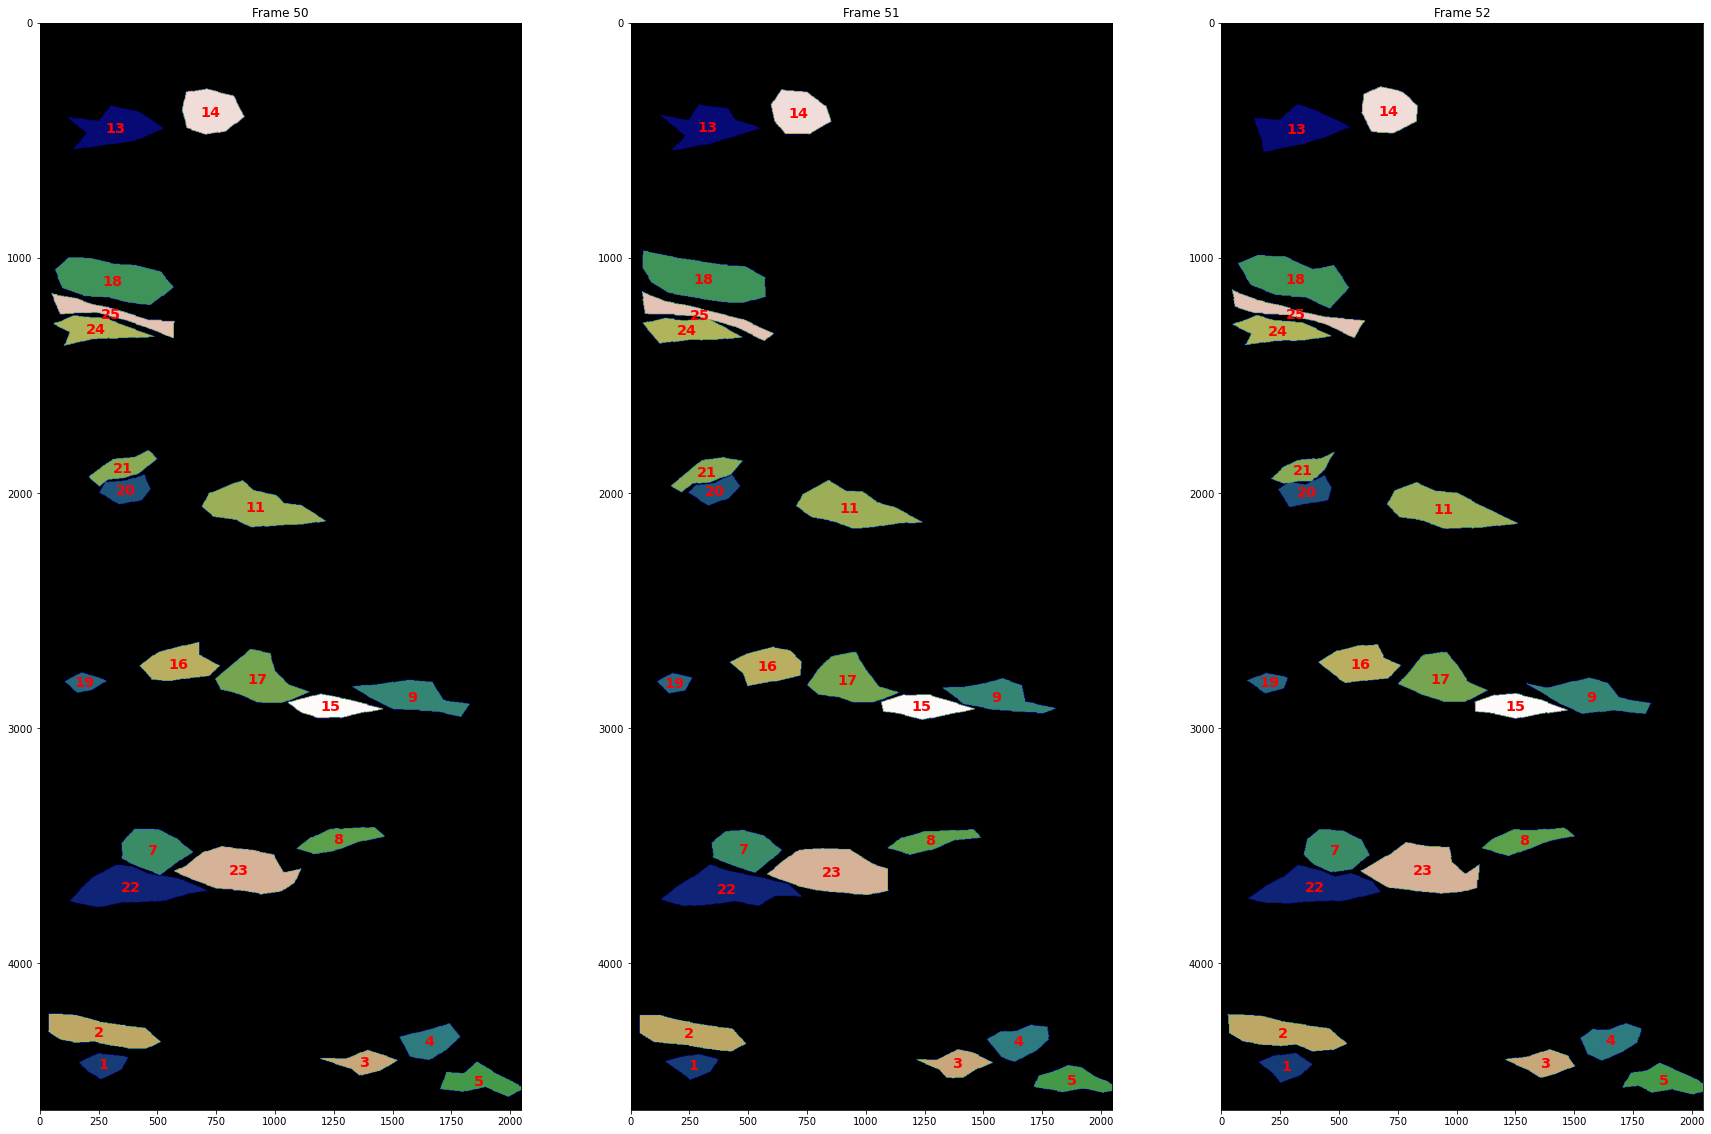

In [10]:
# fig, axs = plt.subplots(1, 3)
# fig.set_size_inches(30, 20)


# for i, frame in enumerate(range(50, 53)):
#     seg_img = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images_nw/02_GT/TRA/man_track{frame:04d}.tif").convert('L')
#     seg_shuf = shuffle_labels(make_np(seg_img))
#     plot_labels(seg_shuf, make_np(seg_img), axs[i], f"Frame {frame}")

# plt.show()


####### Previous resuts can be obtained from the Data located in the data directory  /data/MinaHossain/Cell_Data/Training/6row_images_Trained or 


fig, axs = plt.subplots(1, 3)
fig.set_size_inches(30, 20)


for i, frame in enumerate(range(50, 53)):
    seg_img = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_GT/TRA/man_track{frame:04d}.tif").convert('L')
    seg_shuf = shuffle_labels(make_np(seg_img))
    plot_labels(seg_shuf, make_np(seg_img), axs[i], f"Frame {frame}")

plt.show()

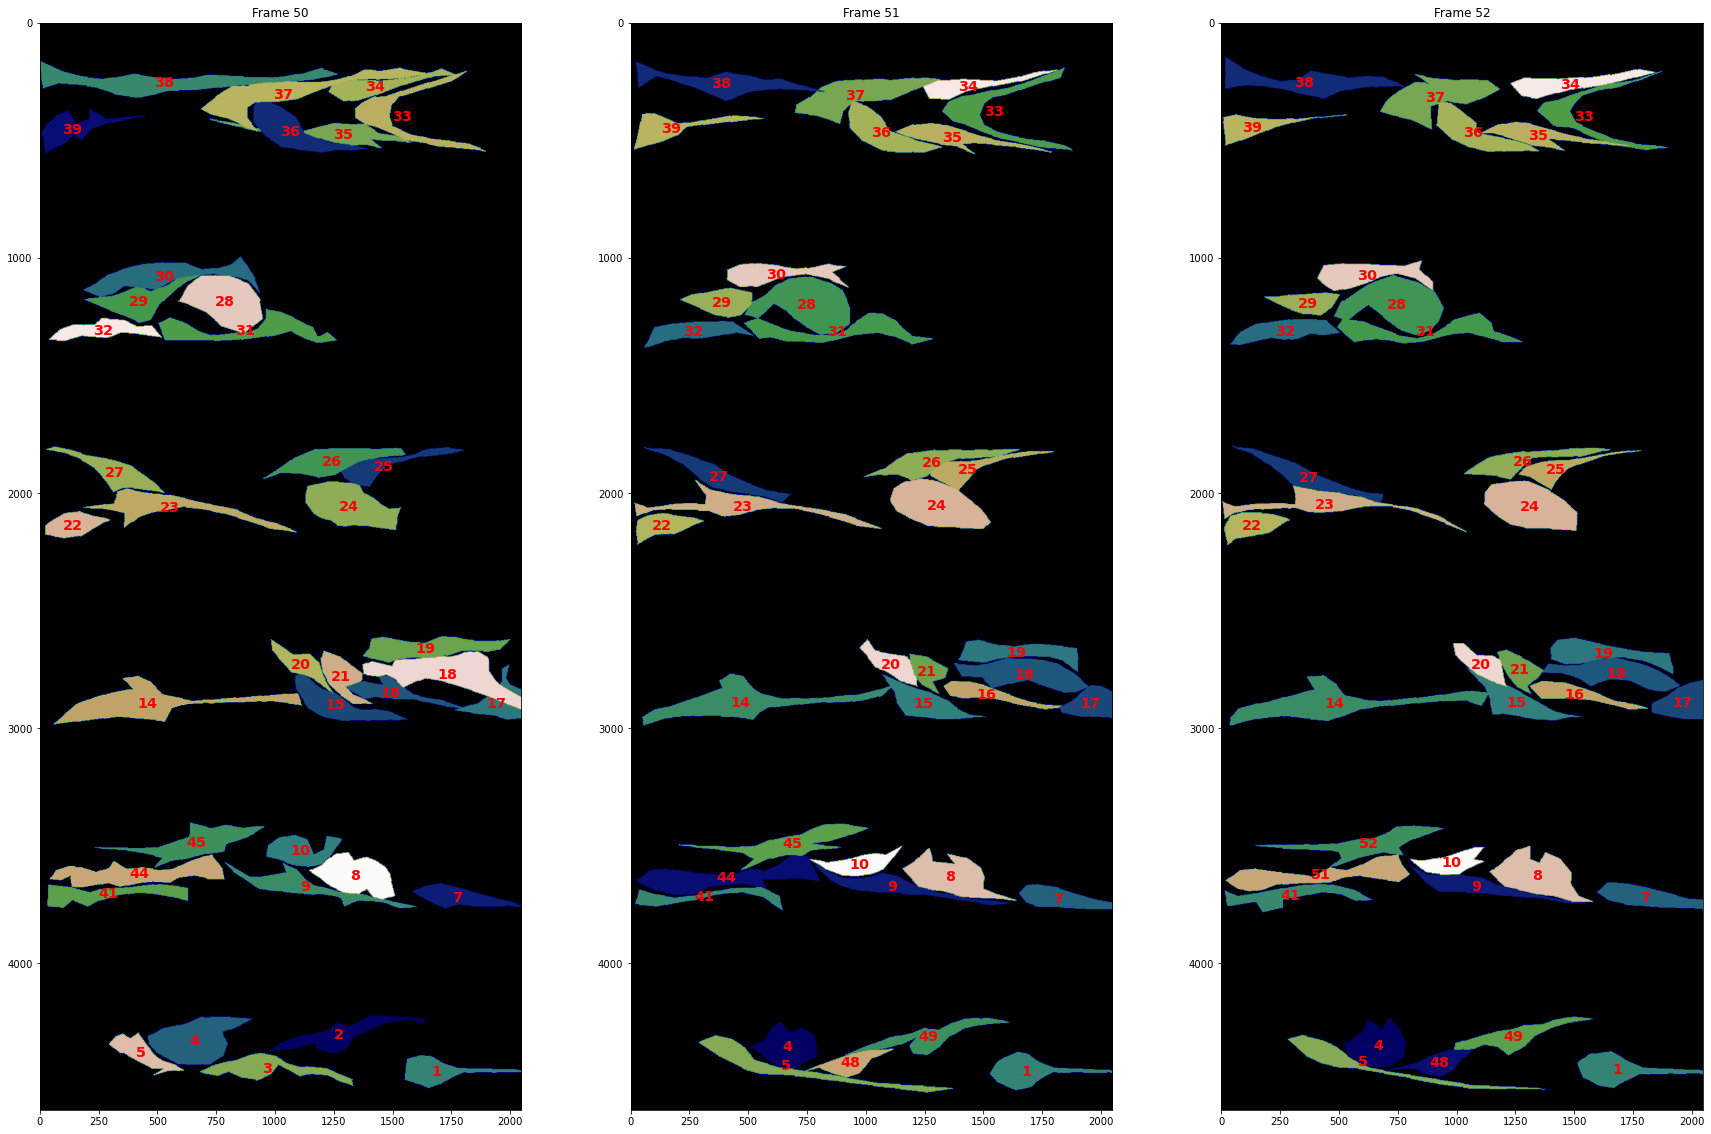

In [12]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(30,20)


for i, frame in enumerate(range(50, 53)):
    seg_img = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_GT/TRA/man_track{frame:04d}.tif").convert('L')
    seg_shuf = shuffle_labels(make_np(seg_img))
    plot_labels(seg_shuf, make_np(seg_img), axs[i], f"Frame {frame}")

plt.show()

In [ ]:
# fig, axs = plt.subplots(1, 4)
# fig.set_size_inches(40, 20)


# for i, frame in enumerate(range(49, 53)):
#     seg_img = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_GT/TRA/man_track{frame:04d}.tif").convert('L')
#     seg_shuf = shuffle_labels(make_np(seg_img))
#     plot_labels(seg_shuf, make_np(seg_img), axs[i], f"Frame {frame}")

# plt.show()

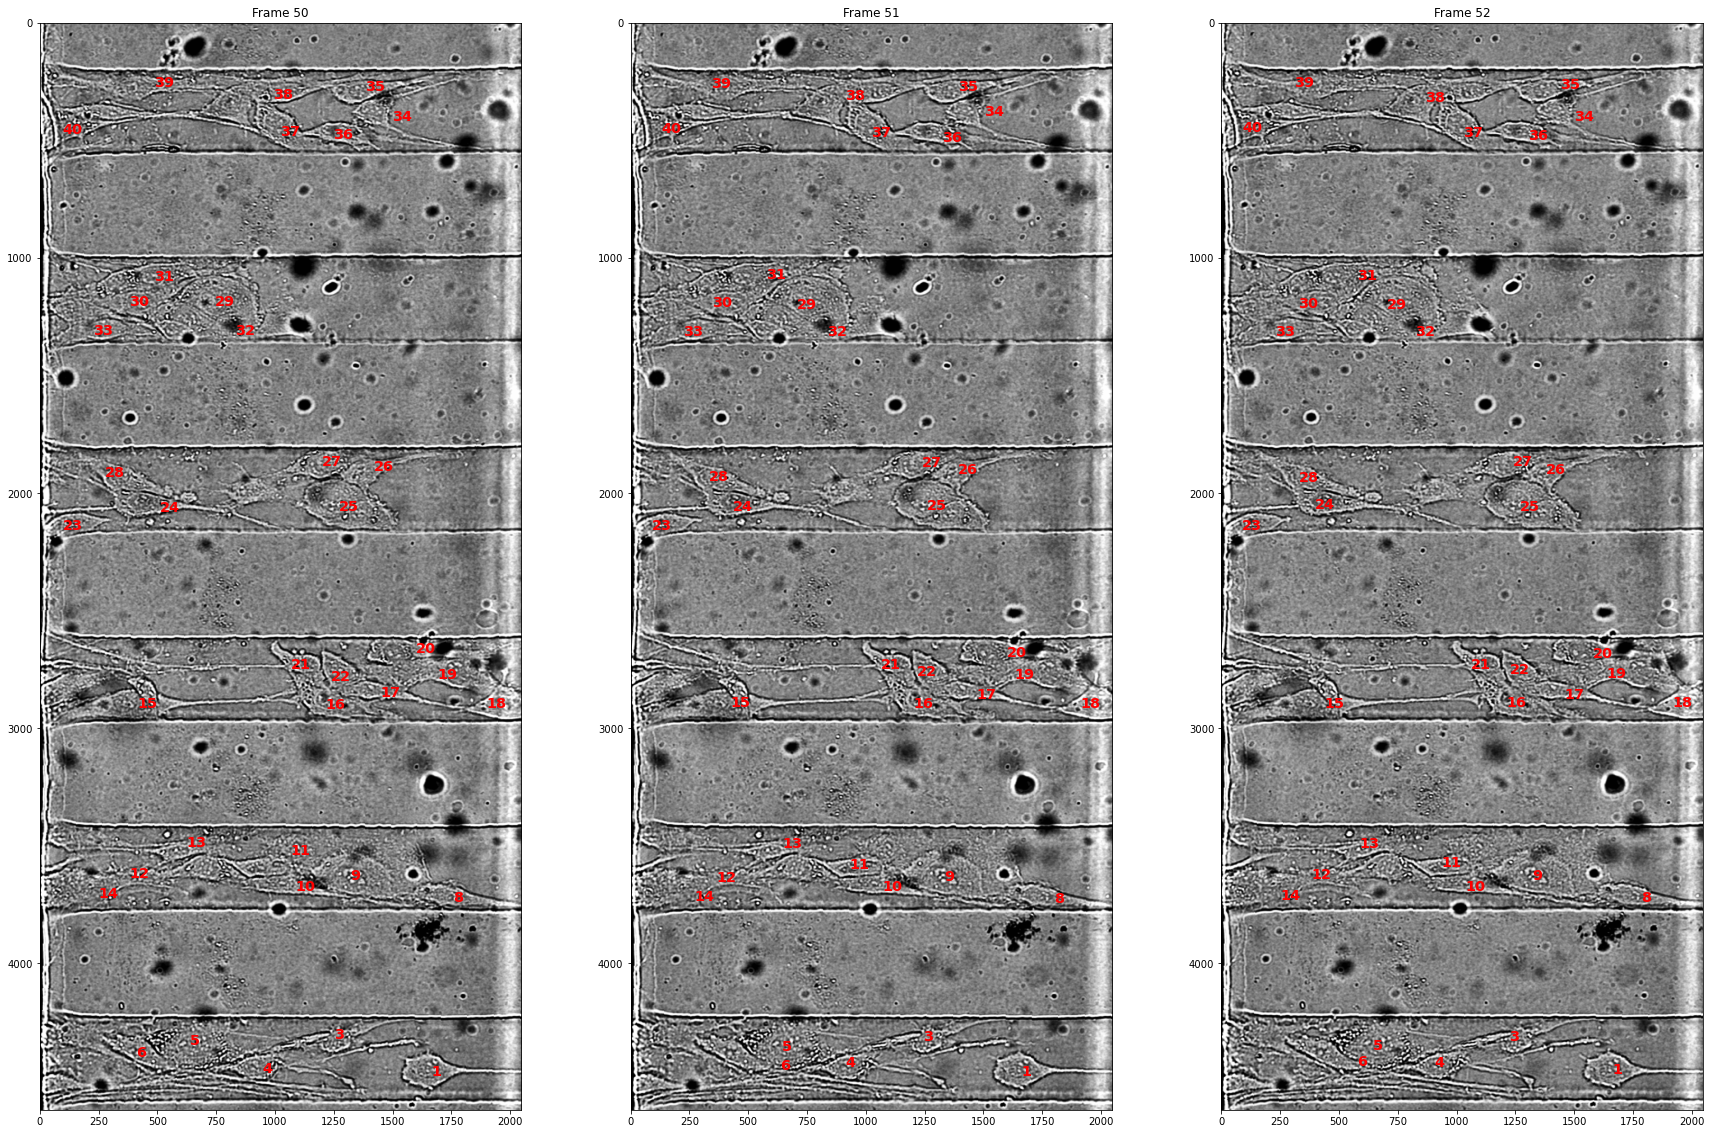

In [10]:

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(30, 20)


for i, frame in enumerate(range(50, 53)):
    seg_lab = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images_nw/02_GT/TRA/man_track{frame:04d}.tif").convert('L')
    seg_img = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images_nw/02/t{frame:04d}.tif").convert('L')
    # seg_shuf = shuffle_labels(make_np(seg_img))
    plot_labels(seg_img, make_np(seg_lab), axs[i], f"Frame {frame}", cmap='gray')

plt.show()

#Plot to show the labelling in original image

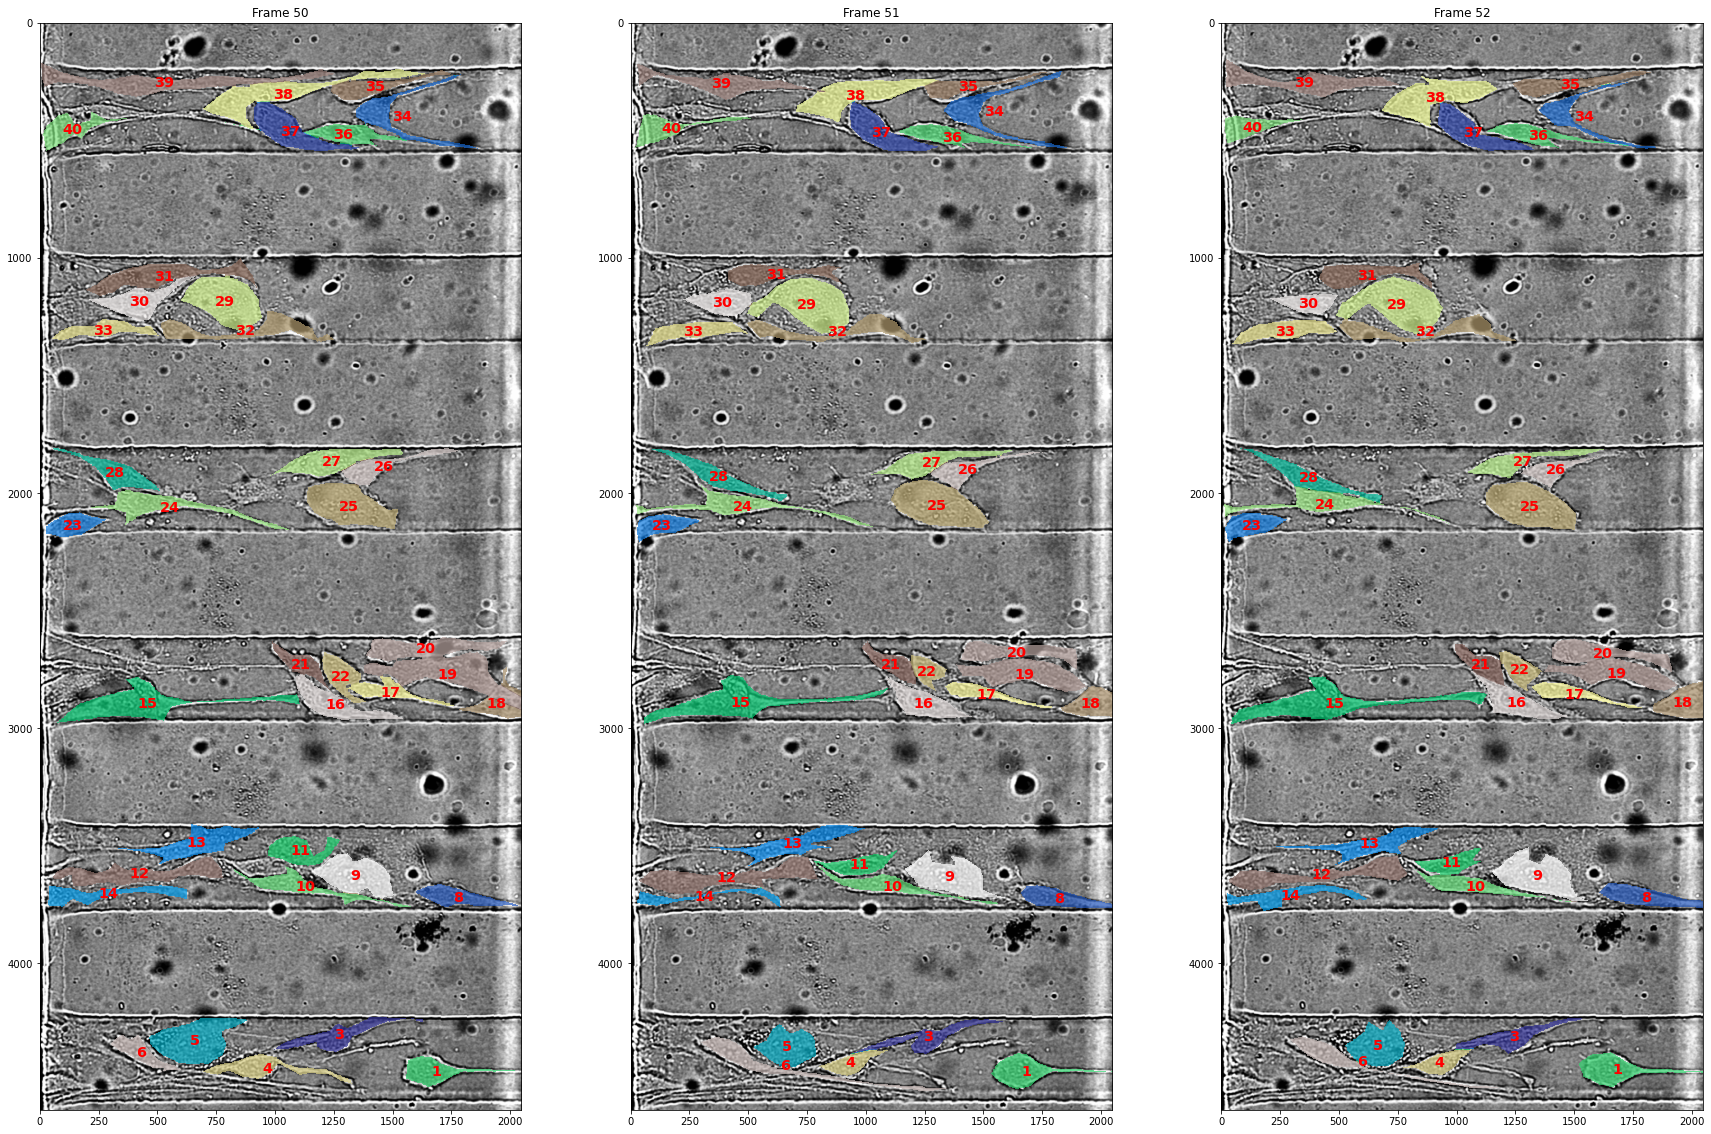

In [11]:
def plot_raw(shuffled, original, ax, title=None,
                txt_args={'color':'red', 'ha':'center', 'va':'center', 
                          'fontsize':'x-large', 'fontweight':'bold'},
                cmap_raw='gray', cmap_seg='gist_earth', alpha=.5):
    ax.imshow(shuffled, cmap=cmap_raw)
    ax.set_title(title)
    
    for label in np.unique(original):
        if label != 0:
            inds = np.argwhere(original == label)
            loc = inds.mean(0)
            ax.text(loc[1], loc[0], str(label), **txt_args)

    tmp_seg = shuffle_labels(make_np(original))
    tmp_seg = np.ma.masked_where(tmp_seg == 0, tmp_seg)
    ax.imshow(tmp_seg, alpha=alpha, cmap=cmap_seg)



fig, axs = plt.subplots(1, 3)
fig.set_size_inches(30, 20)


for i, frame in enumerate(range(50, 53)):
    seg_lab = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images_nw/02_GT/TRA/man_track{frame:04d}.tif").convert('L')
    seg_img = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images_nw/02/t{frame:04d}.tif").convert('L')
    # seg_shuf = shuffle_labels(make_np(seg_img))
    plot_raw(seg_img, make_np(seg_lab), axs[i], f"Frame {frame}", alpha=.7, cmap_seg='terrain')

plt.show()

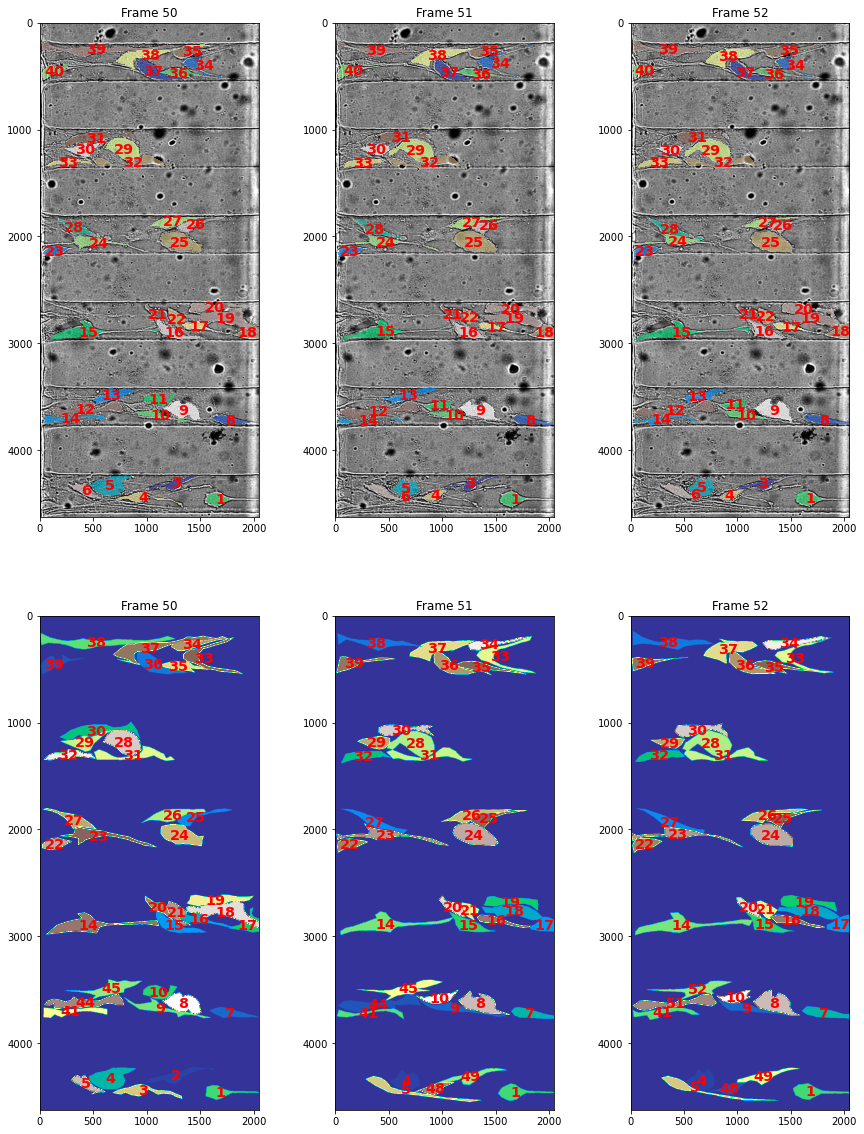

In [8]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15, 20)

start, end = 50, 53

for i, frame in enumerate(range(start, end)):
    seg_lab = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images_nw/02_GT/TRA/man_track{frame:04d}.tif").convert('L')
    seg_img = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images_nw/02/t{frame:04d}.tif").convert('L')
    plot_raw(seg_img, make_np(seg_lab), axs[0, i], f"Frame {frame}", alpha=.7, cmap_seg='terrain')

for i, frame in enumerate(range(start, end)):
    seg_img = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_GT/TRA/man_track{frame:04d}.tif").convert('L')
    seg_shuf = shuffle_labels(make_np(seg_img))
    plot_labels(seg_shuf, make_np(seg_img), axs[1, i], f"Frame {frame}", cmap='terrain')

plt.show()

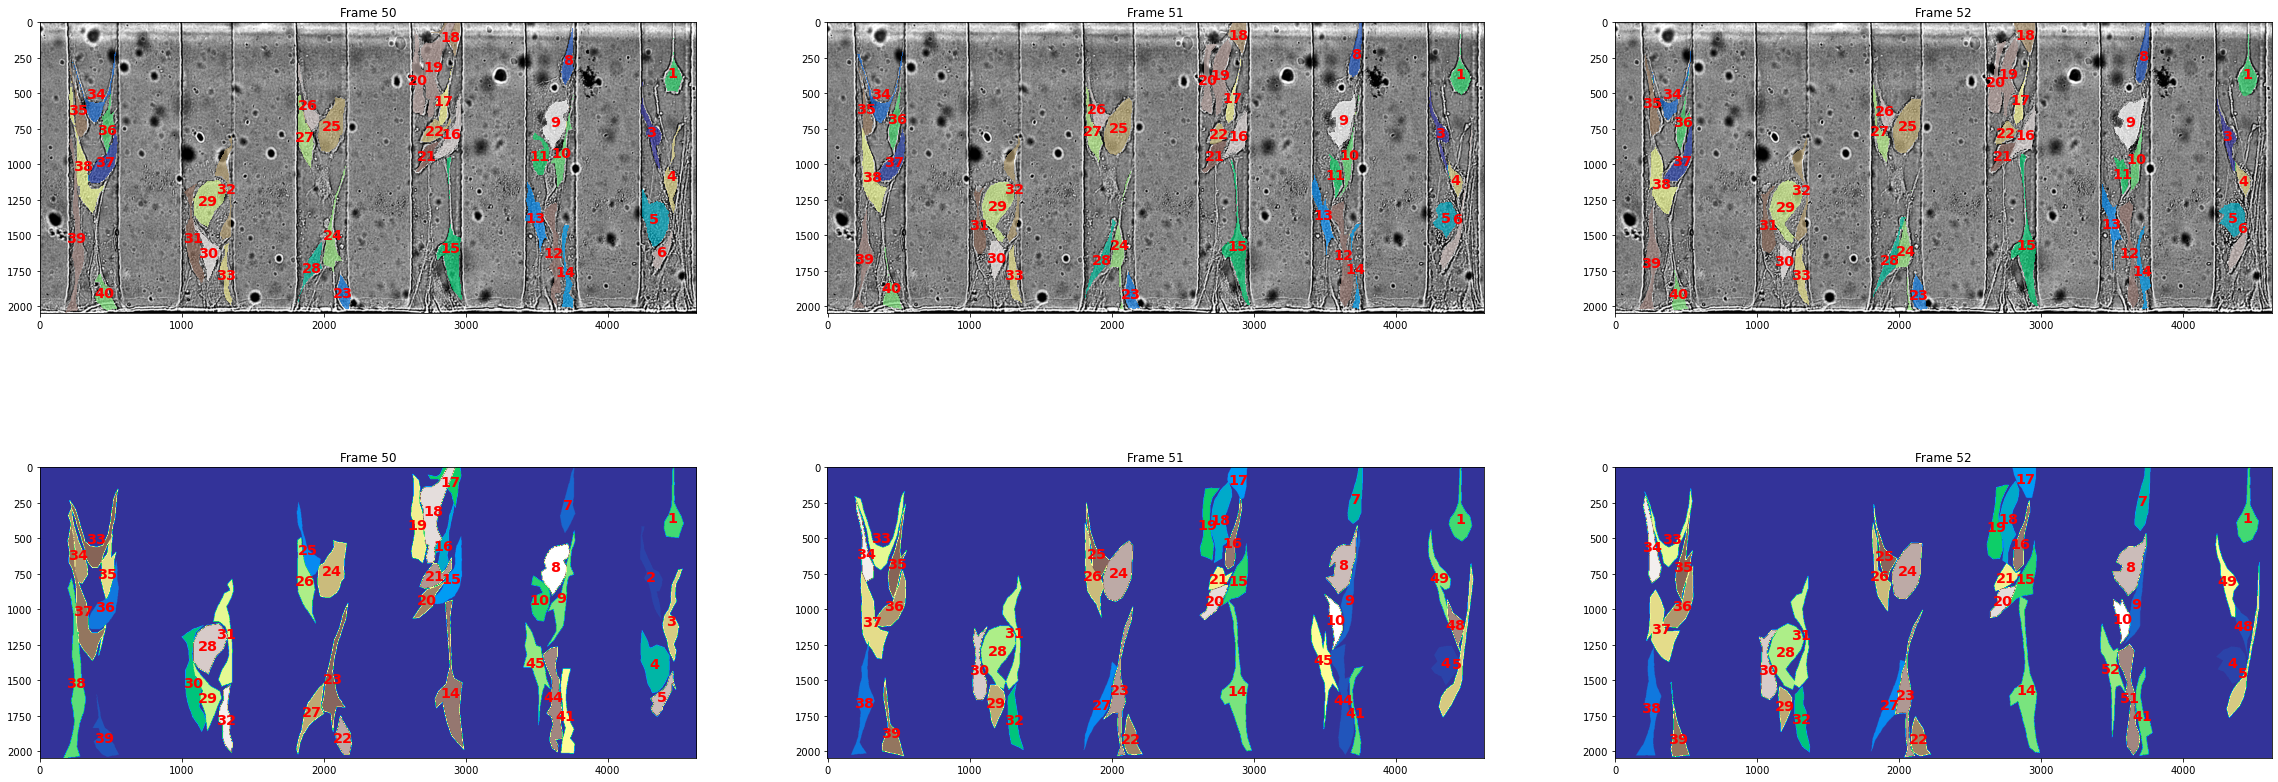

In [9]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(40, 15)

start, end = 50, 53

for i, frame in enumerate(range(start, end)):
    seg_lab = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images_nw/02_GT/TRA/man_track{frame:04d}.tif").convert('L')
    seg_img = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images_nw/02/t{frame:04d}.tif").convert('L')
    plot_raw(np.rot90(seg_img), np.rot90(make_np(seg_lab)), axs[0, i], f"Frame {frame}", alpha=.7, cmap_seg='terrain')

for i, frame in enumerate(range(start, end)):
    seg_img = Image.open(f"/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_GT/TRA/man_track{frame:04d}.tif").convert('L')
    seg_shuf = shuffle_labels(make_np(seg_img))
    plot_labels(np.rot90(seg_shuf), np.rot90(make_np(seg_img)), axs[1, i], f"Frame {frame}", cmap='terrain')

plt.show()